## PROJECT TEXT CLASSIFICATION

GOALS:
Build a text classification model to predict the artist from a piece of text.

In this project we download songs lyrics from 2 artists, U2 and Queen by scrapping web pages  https://musikguru.de/u2/index-10877.html and  https://musikguru.de/queen/index-9274.html
- Download a HTML page with links to songs
- Extract hyperlinks of song pages
- Download and extract the song lyrics
- Vectorize the text using the Bag Of Words method
- Train a classification model that predicts the artist from a piece of text
- Refactor the code into functions
- Write a simple command-line interface for the program

#### Getting links and scrap HTML

The page has 10 links on each page, we go through 3 pages for Nirwana and 20 pages for Queen

In [12]:
import re
from bs4 import BeautifulSoup
import requests
import pickle
import os
from wordcloud import WordCloud
from random import shuffle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import  MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import spacy
from langdetect import detect

Read and write links to 2 files

In [13]:
urls = ['https://musikguru.de/u2/index-10877','https://musikguru.de/queen/index-9274']
i = 1
for url in urls:
    k = 5 if url == urls[0] else 4 #we have 5 pagination pages for u2 and 4 for queen, total 9 files
    url_n = url + '.html'
    for n in range(2, k + 2):
        response = requests.get(url_n)
        html = response.text
        url_n = url + '-' + str(n) + '.html'
        with open(f'html_links/file_origin_{i}.txt', 'w') as f:
            f.write(html)
        i = i + 1

Func to find all files in our folder 'd', returns name of file

In [14]:
def find_files(directory):
    files_names = []
    for entry in os.scandir(directory):
        if (entry.path.endswith('txt') and entry.is_file()):
            files_names.append(entry.path)
    return files_names        

Saving all links to lyric pages in dictionary links {'name_of_song': link}

In [15]:
links = {}
for file in find_files('html_links'):
    with open(file, 'r') as f:
        html = f.read()  
    soup = BeautifulSoup(html)
    for a in soup.find_all('a'):
        if ("LyrOrg") in a.get('class', default = []):
            link = a.get_text()
            links[link] = ('https://musikguru.de' + a.get('href', default = []))

In [16]:
links

{'With or Without You': 'https://musikguru.de/u2/songtext-with-or-without-you-196764.html',
 'Beautiful Day': 'https://musikguru.de/u2/songtext-beautiful-day-62186.html',
 'Miss Sarajevo': 'https://musikguru.de/u2/songtext-miss-sarajevo-298722.html',
 'One': 'https://musikguru.de/u2/songtext-one-196688.html',
 "I Still Haven't Found What I'm Looking for": 'https://musikguru.de/u2/songtext-i-still-haven-t-found-what-i-m-looking-for-62645.html',
 'Sunday Bloody Sunday': 'https://musikguru.de/u2/songtext-sunday-bloody-sunday-196724.html',
 'Pride (In the Name of Love)': 'https://musikguru.de/u2/songtext-pride-in-the-name-of-love-196700.html',
 'Bad': 'https://musikguru.de/u2/songtext-bad-62171.html',
 "You're the Best Thing About Me": 'https://musikguru.de/u2/songtext-you-re-the-best-thing-about-me-2175199.html',
 "Van Diemen's Land": 'https://musikguru.de/u2/songtext-van-diemen-s-land-196749.html',
 'Heartland': 'https://musikguru.de/u2/songtext-heartland-62599.html',
 'Slug': 'https://m

Save lyrics as html text in list array ['song name', 'url', 'author', 'lyric']

In [17]:
array = []
for key, link in links.items():
    try:
        response = requests.get(link)
        response = response.text
        soup = BeautifulSoup(response)
        lyric = soup.body.find(id = 'Lyrics').get_text()
        author = soup.body.find(id = 'Copyright').get_text()
        array.append([key, link, author, lyric])
    except:
        print(link)  

https://musikguru.de
https://musikguru.de
https://musikguru.de


In [18]:
array[0:10]

[['With or Without You',
  'https://musikguru.de/u2/songtext-with-or-without-you-196764.html',
  ' Writer(s): Clayton Adam, Evans David, Hewson Paul David, Mullen Laurence\nLyrics powered by www.musixmatch.com ',
  " See the stone set\nIn your eyes\nSee the thorn twist in your side\nI wait for you\n\nSleight of hand and twist of fate\nOn a bed of nails she makes me wait\nAnd I wait without you\n\nWith or without you\nWith or without you\n\nThrough the storm we reach the shore\nYou give it all but I want more\nAnd I'm waiting for you\n\nWith or without you\nWith or without you\nI can't live\nWith or  without you\n\nAnd you give yourself away\nAnd you give yourself away\nAnd you give\nAnd you give\nAnd you give yourself away\n\nMy hands are tied\nMy body bruised, she's got me with\nNothing to win and\nNothing left to lose\n\nAnd you give yourself away\nAnd you give yourself away\nAnd you give\nAnd you give\nAnd you give yourself away\n\nWith or without you\nWith or without you\nI can't l

In [19]:
len(array)

566

We've got total 566 songs from both bands

Save array in file so we dont need to run requests part of programm again

In [20]:
with open('songs/songName_link_author_lyrics.txt', 'wb') as f:
    pickle.dump(array, f)

### WORK WITH TEXT

Plotting function

In [21]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [22]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
space = ' '

Read file with our texts

In [40]:
with open ('songs/songName_link_author_lyrics.txt', 'rb') as fp:
    songs = pickle.load(fp)

In [41]:
len(songs)

566

In [42]:
songs[0:10]

[['With or Without You',
  'https://musikguru.de/u2/songtext-with-or-without-you-196764.html',
  ' Writer(s): Clayton Adam, Evans David, Hewson Paul David, Mullen Laurence\nLyrics powered by www.musixmatch.com ',
  " See the stone set\nIn your eyes\nSee the thorn twist in your side\nI wait for you\n\nSleight of hand and twist of fate\nOn a bed of nails she makes me wait\nAnd I wait without you\n\nWith or without you\nWith or without you\n\nThrough the storm we reach the shore\nYou give it all but I want more\nAnd I'm waiting for you\n\nWith or without you\nWith or without you\nI can't live\nWith or  without you\n\nAnd you give yourself away\nAnd you give yourself away\nAnd you give\nAnd you give\nAnd you give yourself away\n\nMy hands are tied\nMy body bruised, she's got me with\nNothing to win and\nNothing left to lose\n\nAnd you give yourself away\nAnd you give yourself away\nAnd you give\nAnd you give\nAnd you give yourself away\n\nWith or without you\nWith or without you\nI can't l

Lable our songs U2 = 1, Queen = 0

In [43]:
for song in songs: 
    if 'u2' in song[1]:
        song[1] = 1
    else:
        song[1] = 0


In [49]:
#     normalize names to check for dublicates later 
for val in songs: 
    val[0] = val[0].lower()
    val[0] = re.sub('\(.+|\[|\]', '', val[0])
    val[0] = re.sub('\s-\s.+', '', val[0])
    val[0] = re.sub('\s/\s.+', '', val[0])
    val[2] = re.sub('Writer\(s\):', '', val[2])
    val[2] = re.sub('\\n', '', val[2])
    val[3] = re.sub('\\n', ' ', val[3])
    val[3] = re.sub('\\r', ' ', val[3])
    val[3] = re.sub(' Writer\(s\).+', '', val[3])
    val[3] = re.sub("\\\'", ' ', val[3])
    val[3] = re.sub('\\x00', '', val[3])  
    val[2] = re.sub('Lyrics powered by www.musixmatch.com', '', val[2])

Remove list elements where author is not mentioned (usually its some dialogs)

In [50]:
for song in songs:
    song[2] = re.sub("\s{2,}", ' ', song[2])
    if (song[2] == ' ' or song[2] == ''):
        songs.remove(song)

In [51]:
len(songs)

494

In [52]:
songs[:10]

[['with or without you',
  1,
  ' Clayton Adam, Evans David, Hewson Paul David, Mullen Laurence ',
  ' See the stone set In your eyes See the thorn twist in your side I wait for you  Sleight of hand and twist of fate On a bed of nails she makes me wait And I wait without you  With or without you With or without you  Through the storm we reach the shore You give it all but I want more And I m waiting for you  With or without you With or without you I can t live With or  without you  And you give yourself away And you give yourself away And you give And you give And you give yourself away  My hands are tied My body bruised, she s got me with Nothing to win and Nothing left to lose  And you give yourself away And you give yourself away And you give And you give And you give yourself away  With or without you With or without you I can t live With or without you  With or without you With or without you I can t live With or without you With or without you '],
 ['beautiful day',
  1,
  ' Clay

In [53]:
shuffle(songs)
len(songs)

494

Creating DataFrame from songs

In [111]:
df = pd.DataFrame(songs,columns = ['name','label', 'author', 'lyric'])

In [112]:
df.head()

,name,label,author,lyric
0,tryin' to throw your arms around the world,1,"Clayton Adam, Evans David, Hewson Paul David,...",Six o clock in the morning You re the last to...
1,bijou,0,"May Brian Harold, Deacon John Richard",You and me We are destined You ll agree To...
2,crazy little thing called love,0,Freddie Mercury,This thing called love I just can t handle it...
3,action this day,0,Roger Meddows Taylor,Action This street honey is a mean street Liv...
4,mothers of the disappeared,1,"Bono, Clayton Adam","Midnight, our sons and daughters Were cut do..."


In [113]:
df = df.drop_duplicates(subset = ['name', 'label'])

In [114]:
len(df)

481

Detect language. We have some non English texts, i will remove them

In [115]:
# Detect language of the text
def lang(df):
    def detect_lang(x):
        try:
            return detect(x)
        except:
            return ''
    df['lang'] = df['lyric'].apply(lambda x: detect_lang(x))
    return df

In [116]:
df = lang(df)

In [117]:
df['lang'].unique()

array(['en', 'es', 'de', 'pl', 'nl', 'so'], dtype=object)

In [118]:
df = df.loc[df['lang'] == 'en']

In [119]:
len(df)

475

In [120]:
df = df.reset_index()

In [121]:
df = df.drop('index', axis = 1)

Function to normalzie and lemmanaze corpus, also removing all words <=2 

In [122]:
def short_words(corp):
    words = corp.split(' ')
    words = [word for word in words if len(word)>2]
    return space.join(words)

In [123]:
stop_words = set(['ahh', 'ahhh', 'ahhhhhhhh', 'aaa', 'aaah', 'aah', 'don', 'ooh',
              'yea', 'yeaaaaaaaaaaaaaaaaaaaaaaaaah' 'yeaaaah', 'yeaaah', 'yeeeaaaaaahhhhhh', 'yeeeaaaah', 'yeah',
              'woooh', 'wooooh', 'waaa', 'waaah', 'wah', 'whoa', 'whoo', 'whoooaaa', 'whooooa', 'oooo', 'na'])

In [124]:
def clean_text(corpus):
    res_corp = []
    sp = spacy.load('en_core_web_sm')
    sp.Defaults.stop_words |= stop_words
    for corp in corpus:
        corp = corp.lower()
        corp = re.sub(r"\'",' ', corp)
        corp = re.sub(r'\W',' ', corp)
        corp = re.sub('\d+', ' ', corp) 
        corp = re.sub('\\n', ' ', corp)
        corp = re.sub(r'\s+',' ', corp)        
        corp = short_words(corp)
        results= sp(corp)
        clean_res = []
        for token in results:
            if not token.is_stop:
                clean_res.append(token.lemma_)
        corp = space.join(clean_res)
        res_corp.append(corp)
    return res_corp    
    

Creating corpus from our songs

In [125]:
corpus = clean_text(list(df['lyric']))

In [126]:
len(corpus)

475

Creating matrix Bag Of Words with CountVectorizer

In [127]:
cv = CountVectorizer(stop_words='english')
cv.fit(corpus)
feature_names = cv.get_feature_names()
cv_corpus = cv.transform(corpus)

In [128]:
df_cv = pd.DataFrame(cv_corpus.todense(), columns = feature_names, index=list(df.index))

In [129]:
df_cv.head()

,aagin,aaron,abandon,abbot,abc,able,abraham,abre,abroad,absolutely,abuse,abyface,accent,access,accident,accord,accuse,ace,ache,achieve,aching,achtunddreißig,achtung,acn,acne,acquaint,acrobat,act,action,adam,add,addict,address,adjourn,admiting,ado,adorable,adore,adrift,adult,advantage,adventure,advert,advertise,aerial,afar,affair,affection,afford,afire,afloat,aflood,afraid,africa,african,afternoon,age,aged,agent,aggravation,aggressive,ago,agree,ahead,aid,aim,ain,air,aircraft,airport,aisle,aisuruhito,alarm,album,alcohol,alight,alike,alive,alk,alley,alleyway,allow,alphaville,alright,altar,alter,alternative,alwyas,amazin,amazing,ambition,amen,america,american,ami,amor,amore,amorist,amplification,amâ,anaesthetic,analyse,ancient,andnotcomingdown,anew,angel,angelic,anger,angle,angry,anguish,animal,ann,anne,annialiation,annihilation,annoy,answer,ant,antoinette,anybody,anymore,anytime,apart,apartheid,apartment,ape,aplace,apologise,apothecary,appear,appetite,appian,applause,apple,appliance,appointment,approach,april,aquí,arb,arch,arden,ardentia,ardentian,aren,argue,argument,arm,armchair,armour,army,arrange,arrest,arrive,arrogant,arrow,art,artery,articulate,artist,ashamed,ashe,asian,aside,ask,asleep,aspettare,asphalt,ass,assemble,assetate,assistance,assunder,astaire,astray,asunder,asy,atlantic,atlantico,atm,atmosphere,atom,atomic,attack,attention,attitude,attract,attraction,atv,auntie,aura,australian,authoritiy,auto,automobile,automolove,avail,avalanche,avenue,average,avoid,await,awake,away,awful,awhile,awkward,awoke,aye,babe,babel,baby,babyby,babyface,babylon,backdoor,backdrop,background,backstreet,backwards,backway,bad,baddy,badge,badly,badness,bag,baggage,bah,bail,bain,bake,balance,bali,ball,ballgame,balloon,ballroom,bam,ban,banana,band,bang,banish,bank,banker,banner,bap,bar,...,usher,usual,uuhhh,uzi,vacant,vacation,vague,vain,valentine,valentino,valley,vampire,van,vanilla,vanish,vanity,vehicle,veil,vein,velvet,ven,verse,version,vertical,vertigo,vet,vez,vibró,vice,vicious,victim,victory,video,vie,vietnam,view,vile,village,violet,violin,virgin,virus,visibility,vision,visual,viva,vive,voer,voice,void,volcano,volunteer,voodoo,vorsprung,vow,vuela,vulgar,wage,waggoner,wail,wait,waiter,waiting,waitress,wake,wakin,waking,walk,wall,waltz,wana,wander,wanderlust,wanna,want,wanted,wanting,wants,war,warden,warily,warm,warmer,warmth,warn,warning,warzone,wash,washing,wasn,waste,watch,watchin,watching,watchtower,water,watercolor,watergate,waterless,watn,wave,wavin,way,wayne,weak,weakness,wealthy,weapon,wear,weary,weather,weave,wedding,wednesday,weedkiller,week,weep,weigh,weight,welcome,wender,weren,west,western,wet,wey,whack,wham,whan,whe,wheel,wheeled,wheelin,wherefore,whipser,whirl,whirlwind,whiskey,whisper,whispering,whistle,white,whop,whore,wicked,wide,wife,wiil,wild,william,willing,willow,wily,wim,win,wind,window,wine,wing,wink,winner,winter,wintertime,wipe,wire,wise,wish,wishing,witha,wo,woah,woh,woke,wolf,woman,womb,won,wonder,wonderful,wonderous,wondow,woo,wood,wooh,wool,woork,wop,word,work,workin,working,world,worn,worry,worship,worth,worthwhile,worthy,wouldn,wound,wow,wowowowo,wrap,wrath,wreck,wrench,wrest,wrestle,wretch,wrinkle,wrist,write,wrong,wrtoe,wseetheart,www,xanax,yahweh,yawn,yeaaaaaaaaaaaaaaaaaaaaaaaaah,yeaaaah,year,yearn,yearnin,yearning,yellow,yep,yes,yesterday,yoi,yon,yor,york,youl,yound,young,youth,yup,zach,zap,zarkov,zero,zion,zone,zoo,zoom,zoomin,zooming,zooropa,zuma
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Transform Bag of words with term-frequency times inverse document-frequency

In [130]:
tf = TfidfTransformer()
tf_corpus = tf.fit_transform(cv_corpus)

In [131]:
df_tf = pd.DataFrame(tf_corpus.todense(), columns=feature_names, index=list(df.index))

In [132]:
df_tf.head()

,aagin,aaron,abandon,abbot,abc,able,abraham,abre,abroad,absolutely,abuse,abyface,accent,access,accident,accord,accuse,ace,ache,achieve,aching,achtunddreißig,achtung,acn,acne,acquaint,acrobat,act,action,adam,add,addict,address,adjourn,admiting,ado,adorable,adore,adrift,adult,advantage,adventure,advert,advertise,aerial,afar,affair,affection,afford,afire,afloat,aflood,afraid,africa,african,afternoon,age,aged,agent,aggravation,aggressive,ago,agree,ahead,aid,aim,ain,air,aircraft,airport,aisle,aisuruhito,alarm,album,alcohol,alight,alike,alive,alk,alley,alleyway,allow,alphaville,alright,altar,alter,alternative,alwyas,amazin,amazing,ambition,amen,america,american,ami,amor,amore,amorist,amplification,amâ,anaesthetic,analyse,ancient,andnotcomingdown,anew,angel,angelic,anger,angle,angry,anguish,animal,ann,anne,annialiation,annihilation,annoy,answer,ant,antoinette,anybody,anymore,anytime,apart,apartheid,apartment,ape,aplace,apologise,apothecary,appear,appetite,appian,applause,apple,appliance,appointment,approach,april,aquí,arb,arch,arden,ardentia,ardentian,aren,argue,argument,arm,armchair,armour,army,arrange,arrest,arrive,arrogant,arrow,art,artery,articulate,artist,ashamed,ashe,asian,aside,ask,asleep,aspettare,asphalt,ass,assemble,assetate,assistance,assunder,astaire,astray,asunder,asy,atlantic,atlantico,atm,atmosphere,atom,atomic,attack,attention,attitude,attract,attraction,atv,auntie,aura,australian,authoritiy,auto,automobile,automolove,avail,avalanche,avenue,average,avoid,await,awake,away,awful,awhile,awkward,awoke,aye,babe,babel,baby,babyby,babyface,babylon,backdoor,backdrop,background,backstreet,backwards,backway,bad,baddy,badge,badly,badness,bag,baggage,bah,bail,bain,bake,balance,bali,ball,ballgame,balloon,ballroom,bam,ban,banana,band,bang,banish,bank,banker,banner,bap,bar,...,usher,usual,uuhhh,uzi,vacant,vacation,vague,vain,valentine,valentino,valley,vampire,van,vanilla,vanish,vanity,vehicle,veil,vein,velvet,ven,verse,version,vertical,vertigo,vet,vez,vibró,vice,vicious,victim,victory,video,vie,vietnam,view,vile,village,violet,violin,virgin,virus,visibility,vision,visual,viva,vive,voer,voice,void,volcano,volunteer,voodoo,vorsprung,vow,vuela,vulgar,wage,waggoner,wail,wait,waiter,waiting,waitress,wake,wakin,waking,walk,wall,waltz,wana,wander,wanderlust,wanna,want,wanted,wanting,wants,war,warden,warily,warm,warmer,warmth,warn,warning,warzone,wash,washing,wasn,waste,watch,watchin,watching,watchtower,water,watercolor,watergate,waterless,watn,wave,wavin,way,wayne,weak,weakness,wealthy,weapon,wear,weary,weather,weave,wedding,wednesday,weedkiller,week,weep,weigh,weight,welcome,wender,weren,west,western,wet,wey,whack,wham,whan,whe,wheel,wheeled,wheelin,wherefore,whipser,whirl,whirlwind,whiskey,whisper,whispering,whistle,white,whop,whore,wicked,wide,wife,wiil,wild,william,willing,willow,wily,wim,win,wind,window,wine,wing,wink,winner,winter,wintertime,wipe,wire,wise,wish,wishing,witha,wo,woah,woh,woke,wolf,woman,womb,won,wonder,wonderful,wonderous,wondow,woo,wood,wooh,wool,woork,wop,word,work,workin,working,world,worn,worry,worship,worth,worthwhile,worthy,wouldn,wound,wow,wowowowo,wrap,wrath,wreck,wrench,wrest,wrestle,wretch,wrinkle,wrist,write,wrong,wrtoe,wseetheart,www,xanax,yahweh,yawn,yeaaaaaaaaaaaaaaaaaaaaaaaaah,yeaaaah,year,yearn,yearnin,yearning,yellow,yep,yes,yesterday,yoi,yon,yor,york,youl,yound,young,youth,yup,zach,zap,zarkov,zero,zion,zone,zoo,zoom,zoomin,zooming,zooropa,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Use LatentDirichletAllocation to split corpus to 10 topics and find top 20 words in those topics for transformed and not transformed corpus

In [133]:
n_top_words = 10

In [134]:
lda_tf = LatentDirichletAllocation(n_components=10, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [135]:
lda_cv = LatentDirichletAllocation(n_components=10, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [136]:
lda_tf.fit(tf_corpus)
lda_cv.fit(cv_corpus)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

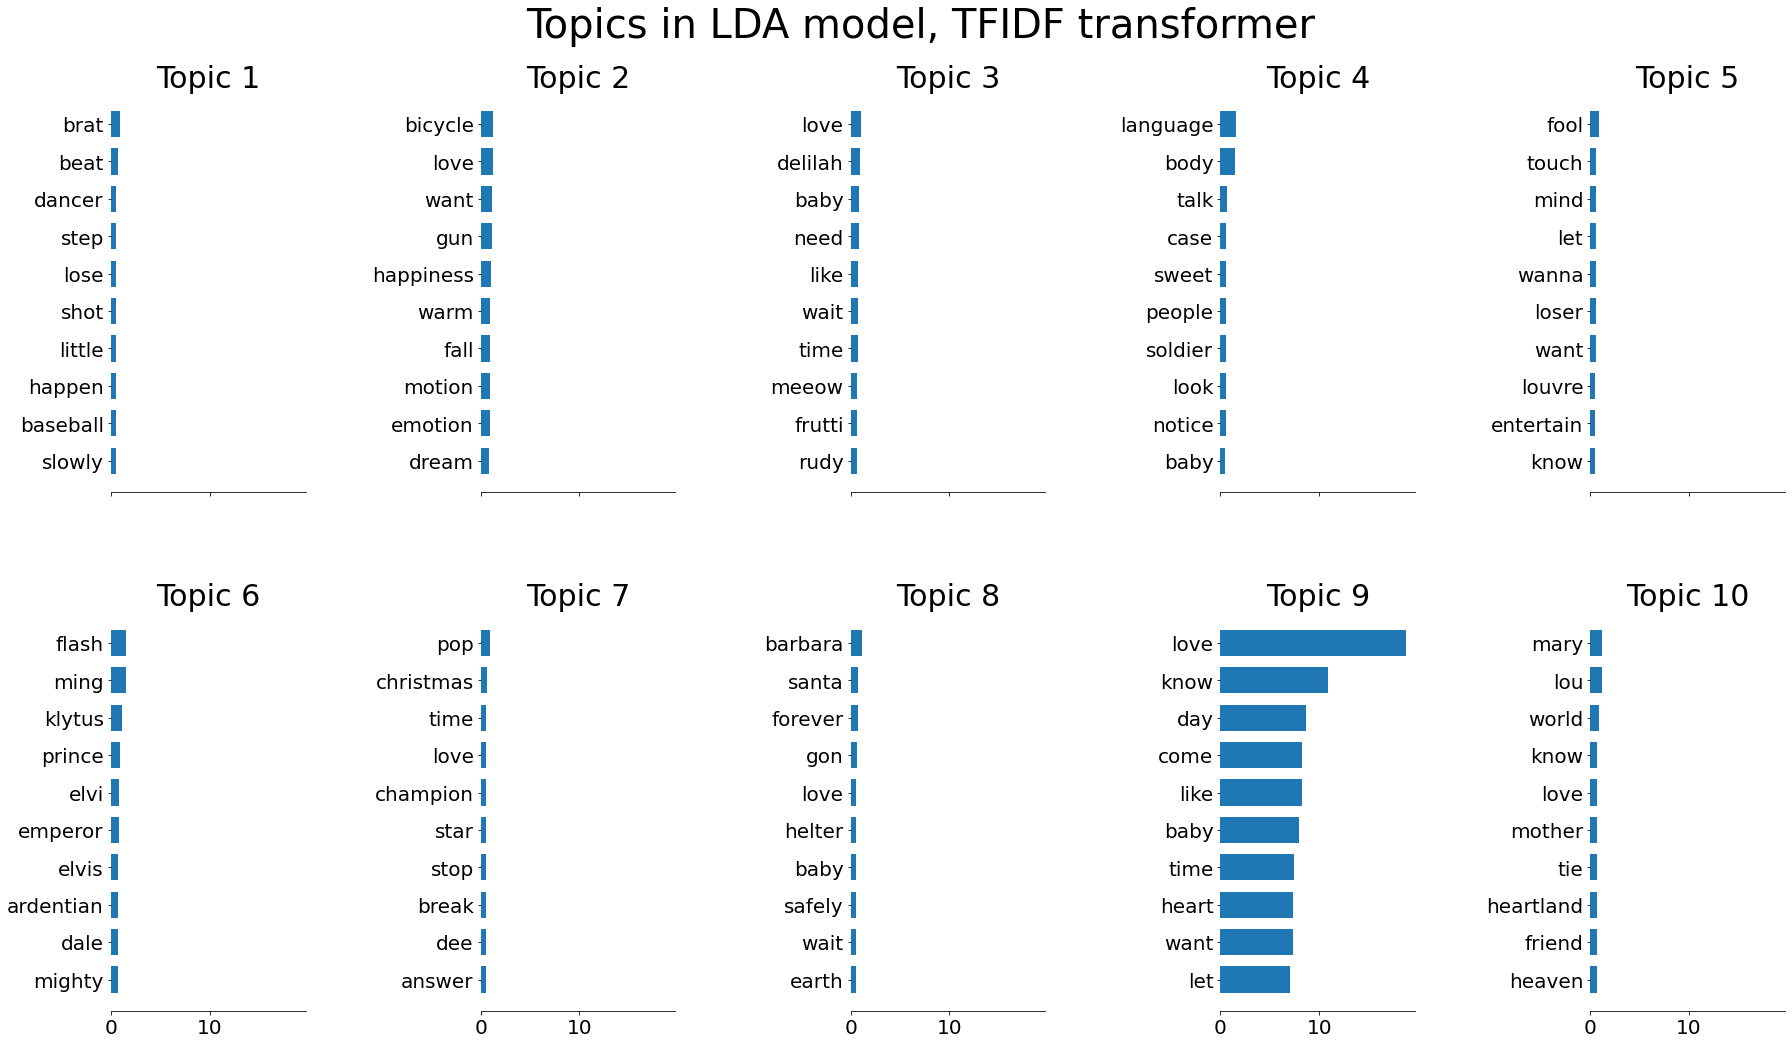

In [137]:
plot_top_words(lda_tf, feature_names, n_top_words, 'Topics in LDA model, TFIDF transformer')

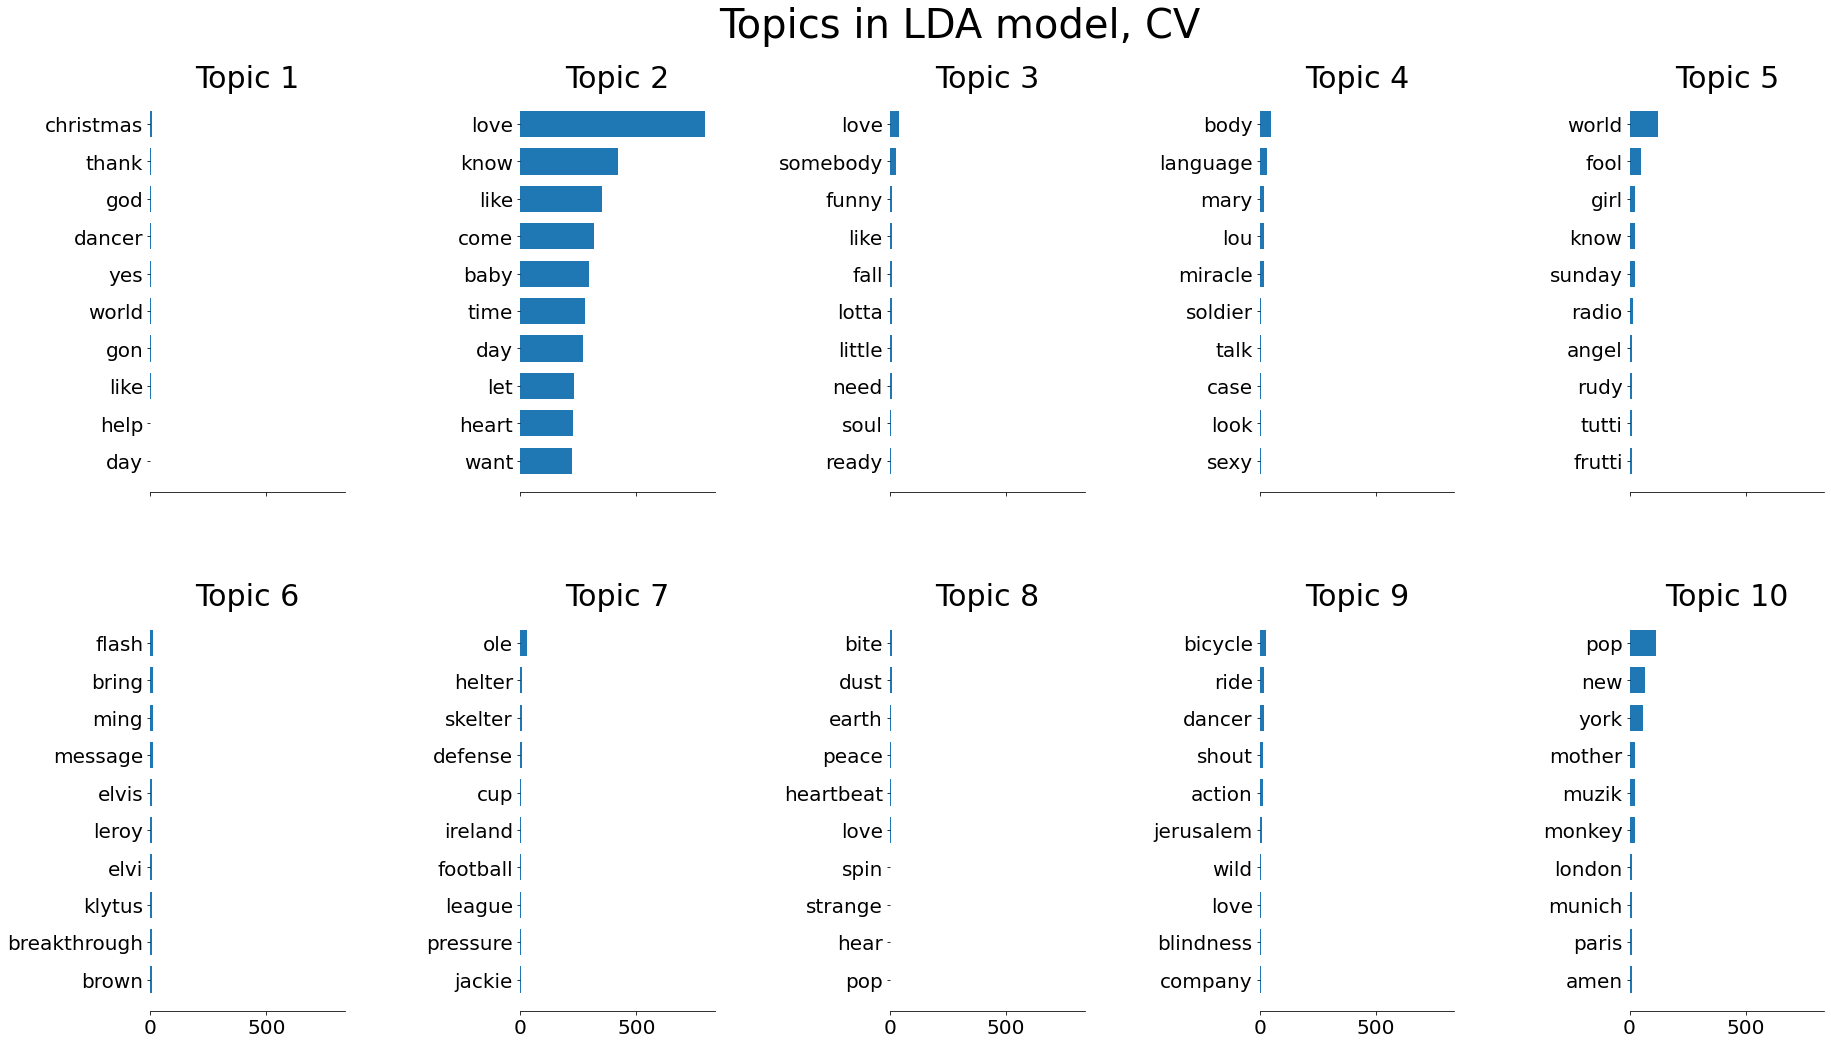

In [138]:
plot_top_words(lda_cv, feature_names, n_top_words, 'Topics in LDA model, CV')

In [139]:
y = df['label']
X = tf_corpus.todense()

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,random_state = 10)

Function to print scores

In [141]:
def print_evaluations(ytrue, ypred, model):
    print(f'How does model {model} score:')
    print(f'The accuracy of the model is: {round(accuracy_score(ytrue, ypred), 3)}')
    print(f'The precision of the model is: {round(precision_score(ytrue, ypred), 3)}')
    print(f'The recall of the model is: {round(recall_score(ytrue, ypred), 3)}')
    print(f'The f1-score of the model is: {round(f1_score(ytrue, ypred), 3)}')
    
    cm = confusion_matrix(ytrue, ypred)
    print(cm)
    return cm

Our test data set

In [142]:
cm = print_evaluations(y_test, y_test, 'Real Scores')

How does model Real Scores score:
The accuracy of the model is: 1.0
The precision of the model is: 1.0
The recall of the model is: 1.0
The f1-score of the model is: 1.0
[[57  0]
 [ 0 62]]


**NAIVE BYERS**

In [143]:
nb = MultinomialNB()

In [144]:
random_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 3, 4, 5, 6, 7]}
nb_gs = GridSearchCV(nb, random_grid, cv = 3, verbose = 1, 
                      n_jobs = -1)
best_nb = nb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 17 candidates, totalling 51 fits


In [145]:
y_test_pred = best_nb.predict(X_test)
y_train_pred = best_nb.predict(X_train)
cm = print_evaluations(y_test, y_test_pred, 'Naive Byers')
print(f'Accuracy train: {accuracy_score(y_train,y_train_pred)}')
print(f'Accuracy test: {accuracy_score(y_test,y_test_pred)}')
print(f'Params: {best_nb.best_params_}')

How does model Naive Byers score:
The accuracy of the model is: 0.756
The precision of the model is: 0.739
The recall of the model is: 0.823
The f1-score of the model is: 0.779
[[39 18]
 [11 51]]
Accuracy train: 1.0
Accuracy test: 0.7563025210084033
Params: {'alpha': 0.001}


**LOGISTIC REGRESSION**

In [146]:
lr = LogisticRegression()

In [147]:
random_grid = {'C': [0.001,0.01,0.1,1,10,100]}
lr_gs = GridSearchCV(lr, random_grid, cv = 3, verbose = 1, 
                      n_jobs = -1)
best_lr = lr_gs.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [148]:
y_test_pred = best_lr.predict(X_test)
y_train_pred = best_lr.predict(X_train)
cm = print_evaluations(y_test, y_test_pred, 'Logistic Regression')
print(f'Accuracy train: {accuracy_score(y_train,y_train_pred)}')
print(f'Accuracy test: {accuracy_score(y_test,y_test_pred)}')
print(f'Params: {best_lr.best_params_}')

How does model Logistic Regression score:
The accuracy of the model is: 0.681
The precision of the model is: 0.65
The recall of the model is: 0.839
The f1-score of the model is: 0.732
[[29 28]
 [10 52]]
Accuracy train: 1.0
Accuracy test: 0.680672268907563
Params: {'C': 10}


**RANDOM FOREST**

In [149]:
rf = RandomForestClassifier()

In [150]:
random_grid = {'max_depth': [3,4,5,6,7,8],
                'n_estimators':[10, 100, 300, 500]} 
rf_gs = GridSearchCV(rf, random_grid, cv = 3, verbose = 1, 
                      n_jobs = -1)
best_rf = rf_gs.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [151]:
best_rf.best_params_

{'max_depth': 5, 'n_estimators': 10}

In [152]:
y_test_pred = best_rf.predict(X_test)
y_train_pred = best_rf.predict(X_train)
cm = print_evaluations(y_test, y_test_pred, 'Random Forest')
print(f'Accuracy train: {accuracy_score(y_train,y_train_pred)}')
print(f'Accuracy test: {accuracy_score(y_test,y_test_pred)}')
print(f'Params: {best_rf.best_params_}')

How does model Random Forest score:
The accuracy of the model is: 0.546
The precision of the model is: 0.538
The recall of the model is: 0.903
The f1-score of the model is: 0.675
[[ 9 48]
 [ 6 56]]
Accuracy train: 0.7443820224719101
Accuracy test: 0.5462184873949579
Params: {'max_depth': 5, 'n_estimators': 10}


Naive Byers has better predictions than other models

### Evaluate Naive Byers model

In [163]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

In [165]:
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
          'fn': cm[1, 0], 'tp': cm[1, 1]}

In [175]:
cv_results = cross_validate(best_nb, X, y, cv=5, scoring=confusion_matrix_scorer)

Fitting 3 folds for each of 17 candidates, totalling 51 fits
Fitting 3 folds for each of 17 candidates, totalling 51 fits
Fitting 3 folds for each of 17 candidates, totalling 51 fits
Fitting 3 folds for each of 17 candidates, totalling 51 fits
Fitting 3 folds for each of 17 candidates, totalling 51 fits


In [176]:
# Getting the test set true positive scores
print(cv_results['test_tp'])

[46 49 43 44 42]


In [177]:
# Getting the test set false negative scores
print(cv_results['test_fn'])

[ 8  5 11 10 11]


### Draw a Word Cloud

Word cloud for Queen

In [153]:
index_q = df.loc[df['label'] == 0].index

In [154]:
corpus_q = [corpus[index] for index in index_q]

In [155]:
text_queen = space.join(corpus_q)

<Figure size 432x288 with 0 Axes>

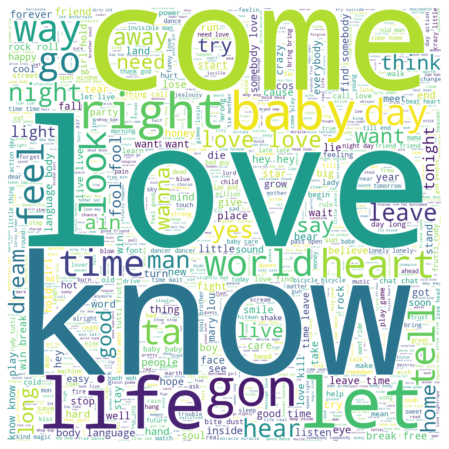

<Figure size 432x288 with 0 Axes>

In [156]:
wc = WordCloud(background_color="white", 
    width = 1000, 
    height = 1000, 
    max_words=2000, 
    contour_width=3, 
    contour_color='steelblue')

wc.generate(text_queen)

plt.figure(figsize = (8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('cloud_queen.png')
plt.figure()

Word Cloud for U2

In [157]:
index_u2 = df.loc[df['label'] == 1].index

In [158]:
corpus_u2 = [corpus[index] for index in index_u2]

In [159]:
text_u2 = space.join(corpus_u2)

<Figure size 432x288 with 0 Axes>

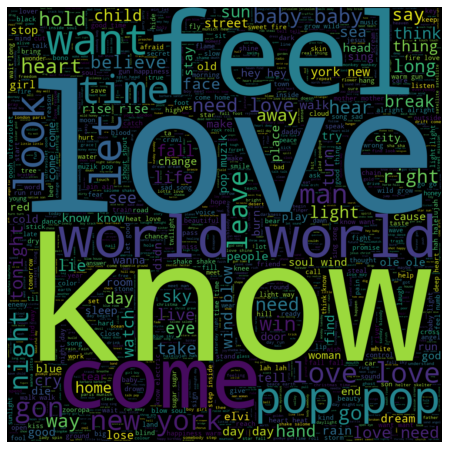

<Figure size 432x288 with 0 Axes>

In [160]:
wc_ = WordCloud(background_color="black", 
    width = 1000, 
    height = 1000, 
    max_words = 2000,           
    contour_width=3, 
    contour_color='steelblue')

wc_.generate(text_u2)

plt.figure(figsize = (8,8))
plt.imshow(wc_, interpolation='bilinear')
plt.axis("off")
plt.savefig('cloud_u2.png')
plt.figure()

As we can see our texts have pretty same most frquent words, it's hard to classify them